In [2]:
import pandas as pd
from sodapy import Socrata
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from  statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [3]:
# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofchicago.org",
                 "3VnxtMFPzsCIscs0iygYCsu9x",
                 username="rforouza@unb.ca",
                 password="Roozbeh123f",
                 timeout=1000)

In [4]:
#Pickups per Community Areas Before the Pandemic 
results = client.get("wrvz-psew", select = 'pickup_community_area,COUNT(pickup_census_tract) as Count', 
                     where="trip_start_timestamp between '2019-03-01T12:00:00' and '2020-02-28T12:00:00'",
                     group = "pickup_community_area", limit = 1000000)
results_df = pd.DataFrame.from_records(results)
before = results_df
#before.to_csv('C:/term paper/data/modified/from code/before_pick_volume.csv')

#Pickups per Community Areas After the Pandemic 
results = client.get("wrvz-psew", select = 'pickup_community_area,COUNT(pickup_census_tract) as Count', 
                     where="trip_start_timestamp between '2020-03-01T12:00:00' and '2021-02-28T12:00:00'",
                     group = "pickup_community_area", limit = 1000000)
results_df = pd.DataFrame.from_records(results)
after = results_df
#after.to_csv('C:/term paper/data/modified/from code/after_pick_volume.csv')

In [ ]:
#Daily Count query
results = client.get("wrvz-psew", select = 'date_trunc_ymd(trip_start_timestamp) as date,COUNT(pickup_census_tract) as Count', 
                     where="trip_start_timestamp between '2019-03-01T12:00:00' and '2021-02-28T12:00:00'",
                     group = "date", limit = 1000000)
daily_count = pd.DataFrame.from_records(results)
daily_count['date_time_string']  = daily_count.apply(lambda row : row.date[0:10], axis = 1)
daily_count['date_time']  = daily_count.apply(lambda row : datetime.datetime.strptime(row['date_time_string'],'%Y-%m-%d'), axis = 1)
daily_count['Count_int']  = daily_count.apply(lambda row : int(row.Count), axis = 1)

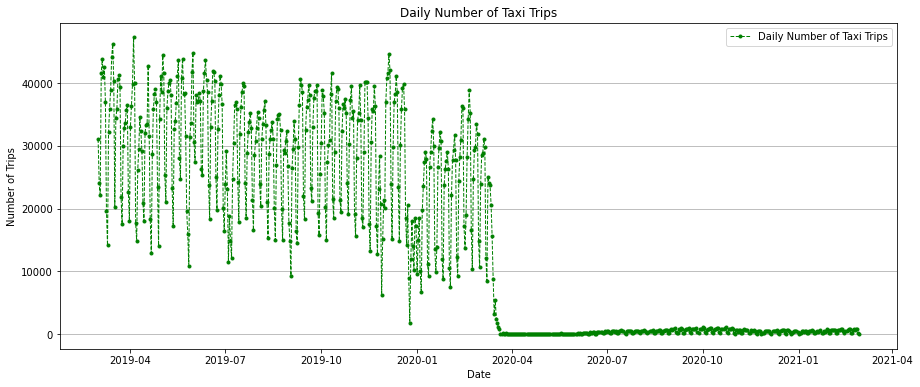

In [9]:
#Plotting daily number of taxi trips
plt.figure(figsize = [15,6])
ax = plt.gca()
plt1 = plt.plot(daily_count.date_time, daily_count['Count_int'], color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Daily Number of Taxi Trips')
plt.legend()
plt.xlabel('Date') 
# naming the y axis 
plt.ylabel('Number of Trips')
plt.title('Daily Number of Taxi Trips') 
ax.yaxis.grid(True)

Text(0.5, 1.0, ' Daily Trips')

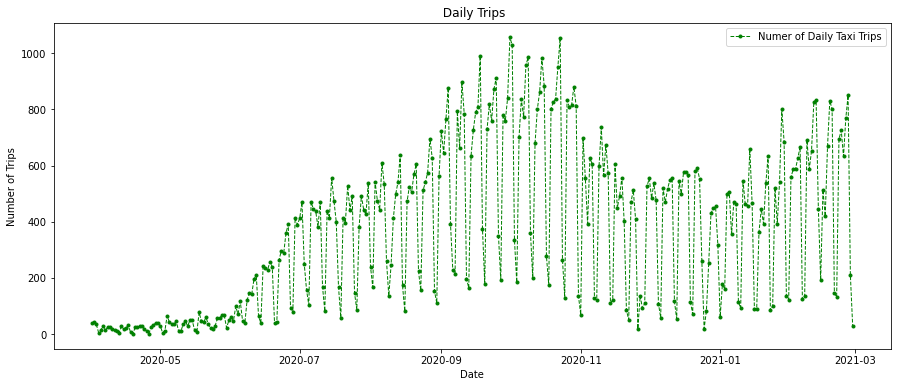

In [10]:
#Plotting daily trips after pandemic
daily_count_after = daily_count.loc[daily_count.date_time>=datetime.datetime(2020,4, 1)]
plt.figure(figsize = [15,6])
ax = plt.gca()
plt1 = plt.plot(daily_count_after.date_time, daily_count_after['Count_int'], color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Numer of Daily Taxi Trips')
plt.legend()
plt.xlabel('Date') 
# naming the y axis 
plt.ylabel('Number of Trips')
plt.title(' Daily Trips') 

In [ ]:
#loading the Cases over time
Case_day = pd.read_csv('data/COVID-19_Daily_Cases__Deaths__and_Hospitalizations.csv')
Case_day = Case_day[Case_day['Date'].isnull()==False] #Removing Null dates 
#Converting string dates to Datetime
Case_day['date_time']  = Case_day.apply(lambda row : datetime.datetime.strptime(row['Date'],'%m/%d/%Y'), axis = 1)
Case_day.sort_values (['date_time'], ascending=[1],inplace = True)

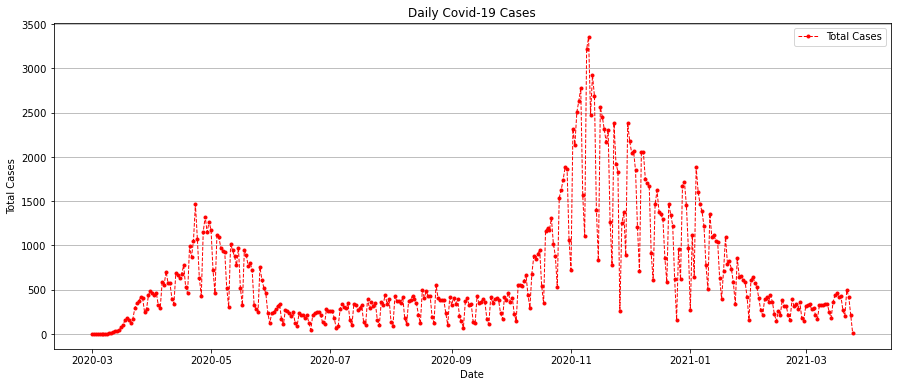

In [12]:
#Plotting Daily Covid-19 Cases
plt.figure(figsize = [15,6])
ax = plt.gca()
plt1 = plt.plot(Case_day.date_time, Case_day['Cases - Total'], color='red', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='red', markersize=3,label='Total Cases')
plt.legend()
plt.xlabel('Date') 
# naming the y axis 
plt.ylabel('Total Cases')
plt.title('Daily Covid-19 Cases')
ax.yaxis.grid(True)

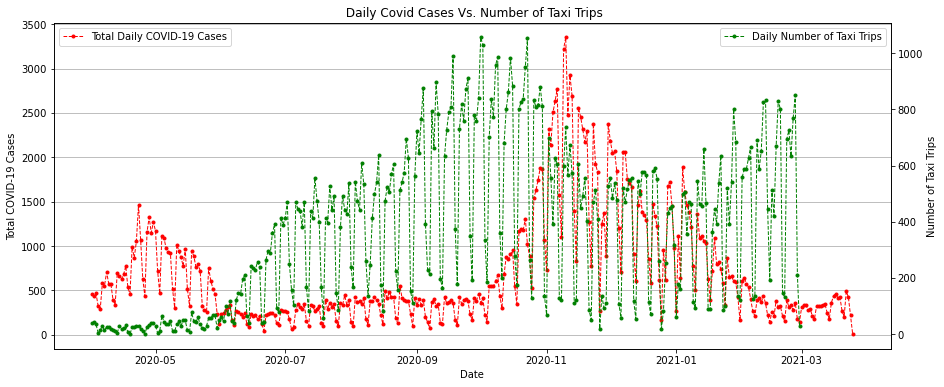

In [13]:
#plotting daily covid cases Vs. number of taxi trips
plt.figure(figsize = [15,6])
ax1 = plt.gca()
plt1 = ax1.plot(Case_day.date_time.loc[Case_day.date_time>=datetime.datetime(2020,4, 1)], Case_day.loc[Case_day.date_time>=datetime.datetime(2020,4, 1)]['Cases - Total'], color='red', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='red', markersize=3,label='Total Daily COVID-19 Cases')
plt.xlabel('Date') 
ax1.legend(loc='upper left')
# naming the y axis 
plt.ylabel('Total COVID-19 Cases')
plt.title(' Daily Covid Cases Vs. Number of Taxi Trips') 
ax2 = ax1.twinx()
pl2 =ax2.plot(daily_count_after.date_time, daily_count_after['Count_int'], color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Daily Number of Taxi Trips')
ax2.set_ylabel('Number of Taxi Trips')

ax2.legend(loc='upper right')
ax1.yaxis.grid(True)

In [14]:
#Calculating travel time index after 2019
results = client.get("wrvz-psew", select = 'date_trunc_ymd(trip_start_timestamp) as date,SUM(trip_miles) as Trip_miles, Sum(trip_seconds) as Trip_seconds', 
                     where="trip_start_timestamp between '2019-03-01T12:00:00' and '2021-02-28T12:00:00'",
                     group = "date", limit = 1000000)
Travel_time_df = pd.DataFrame.from_records(results)
Travel_time_df['Trip_miles_']  = Travel_time_df.apply(lambda row : float(row.Trip_miles), axis = 1)
Travel_time_df['Trip_seconds_']  = Travel_time_df.apply(lambda row : float(row.Trip_seconds), axis = 1)
Travel_time_df['TravelTimeIndex'] = Travel_time_df['Trip_miles_']/Travel_time_df['Trip_seconds_']*3600
Travel_time_df['date_time_string']  = Travel_time_df.apply(lambda row : row.date[0:10], axis = 1)
Travel_time_df['date_time']  = Travel_time_df.apply(lambda row : datetime.datetime.strptime(row['date_time_string'],'%Y-%m-%d'), axis = 1)


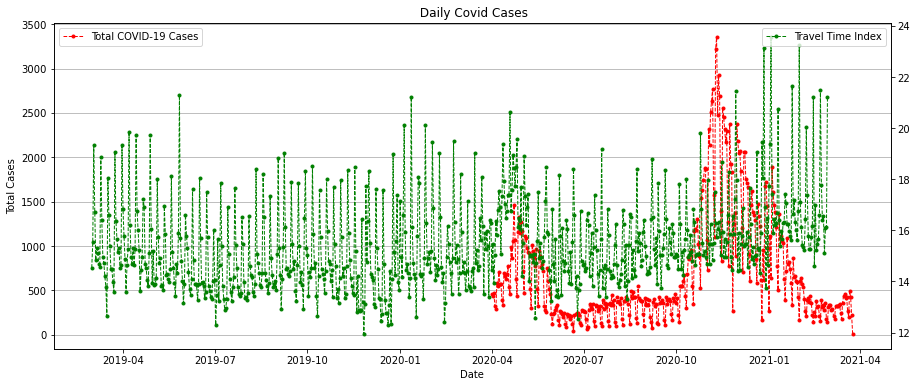

In [15]:
plt.figure(figsize = [15,6])
ax1 = plt.gca()
plt1 = ax1.plot(Case_day.date_time.loc[Case_day.date_time>=datetime.datetime(2020,4, 1)], Case_day.loc[Case_day.date_time>=datetime.datetime(2020,4, 1)]['Cases - Total'], color='red', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='red', markersize=3,label='Total COVID-19 Cases')
plt.xlabel('Date') 
ax1.legend(loc='upper left')
# naming the y axis 
plt.ylabel('Total Cases')
plt.title(' Daily Covid Cases') 
ax2 = ax1.twinx()
pl2 =ax2.plot(Travel_time_df.loc[Travel_time_df.date_time>=datetime.datetime(2017,4, 1)].date_time, Travel_time_df.loc[Travel_time_df.date_time>=datetime.datetime(2017,4, 1)]['TravelTimeIndex'], color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Travel Time Index')
ax2.legend(loc='upper right')
ax1.yaxis.grid(True)

In [16]:
#Calculating weekly travel time index
Travel_time_df_weekly = Travel_time_df.loc[Travel_time_df.date_time>=datetime.datetime(2017,4, 1)][['Trip_seconds_','Trip_miles_','date_time']]
#Crearing year-week date column
Travel_time_df_weekly ['year_week'] = Travel_time_df_weekly.apply(lambda row : row.date_time.strftime('%Y-%W'), axis = 1 )
#Aggregating weekly
Travel_time_df_weekly = Travel_time_df_weekly.groupby(['year_week']).agg(
{
    'Trip_seconds_':'sum',
    'Trip_miles_':'sum',
    'date_time':'first'
})
Travel_time_df_weekly = Travel_time_df_weekly.rename(columns={'date_time': 'week_start_date'})
Travel_time_df_weekly['Average_Travel_Speed'] = Travel_time_df_weekly['Trip_miles_']/Travel_time_df_weekly['Trip_seconds_']*3600

In [17]:
#Creating weekly cases dataframe 
Case_day ['year_week'] = Case_day.apply(lambda row : row.date_time.strftime('%Y-%W'), axis = 1)
##Aggregating weekly
case_weekly = Case_day.groupby(['year_week']).agg(
{
    'Cases - Total':'sum',
    'date_time':'first'
})
case_weekly = case_weekly.rename(columns={'date_time': 'week_start_date'})

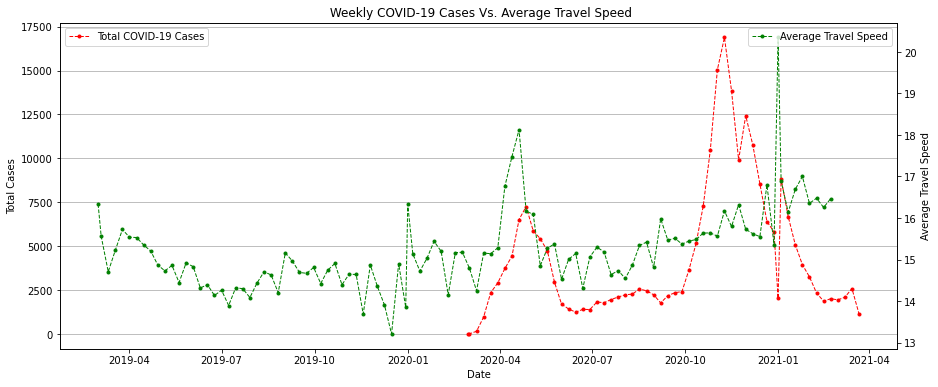

In [18]:
#plotting weekly COVID-19 cases Vs. average travel speed
plt.figure(figsize = [15,6])
ax1 = plt.gca()
plt1 = ax1.plot(case_weekly.week_start_date, case_weekly['Cases - Total'], color='red', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='red', markersize=3,label='Total COVID-19 Cases')
plt.xlabel('Date') 
ax1.legend(loc='upper left')
# naming the y axis 
plt.ylabel('Total Cases')
plt.title(' Weekly COVID-19 Cases Vs. Average Travel Speed') 
ax2 = ax1.twinx()
pl2 =ax2.plot(Travel_time_df_weekly.week_start_date, Travel_time_df_weekly['Average_Travel_Speed'], color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Average Travel Speed')
ax2.set_ylabel('Average Travel Speed')
ax2.legend(loc='upper right')
ax1.yaxis.grid(True)

In [19]:
#Calculating travel time index after 2013
results = client.get("wrvz-psew", select = 'date_trunc_ymd(trip_start_timestamp) as date,SUM(trip_miles) as Trip_miles, Sum(trip_seconds) as Trip_seconds', 
                     where="trip_start_timestamp between '2013-01-01T12:00:00' and '2021-02-28T12:00:00'",
                     group = "date", limit = 1000000)
Travel_time_df = pd.DataFrame.from_records(results)
Travel_time_df['Trip_miles_']  = Travel_time_df.apply(lambda row : float(row.Trip_miles), axis = 1)
Travel_time_df['Trip_seconds_']  = Travel_time_df.apply(lambda row : float(row.Trip_seconds), axis = 1)
Travel_time_df['TravelTimeIndex'] = Travel_time_df['Trip_miles_']/Travel_time_df['Trip_seconds_']*3600
Travel_time_df['date_time_string']  = Travel_time_df.apply(lambda row : row.date[0:10], axis = 1)
Travel_time_df['date_time']  = Travel_time_df.apply(lambda row : datetime.datetime.strptime(row['date_time_string'],'%Y-%m-%d'), axis = 1)


In [20]:
#Calculating weekly travel time index  
Travel_time_df_weekly = Travel_time_df[['Trip_seconds_','Trip_miles_','date_time']]
#Crearing year-week date column
Travel_time_df_weekly ['year_week'] = Travel_time_df_weekly.apply(lambda row : row.date_time.strftime('%Y-%W'), axis = 1 )
#Aggregating weekly
Travel_time_df_weekly = Travel_time_df_weekly.groupby(['year_week']).agg(
{
    'Trip_seconds_':'sum',
    'Trip_miles_':'sum',
    'date_time':'first'
})
Travel_time_df_weekly = Travel_time_df_weekly.rename(columns={'date_time': 'week_start_date'})
Travel_time_df_weekly['travel_time_index'] = Travel_time_df_weekly['Trip_miles_']/Travel_time_df_weekly['Trip_seconds_']*3600

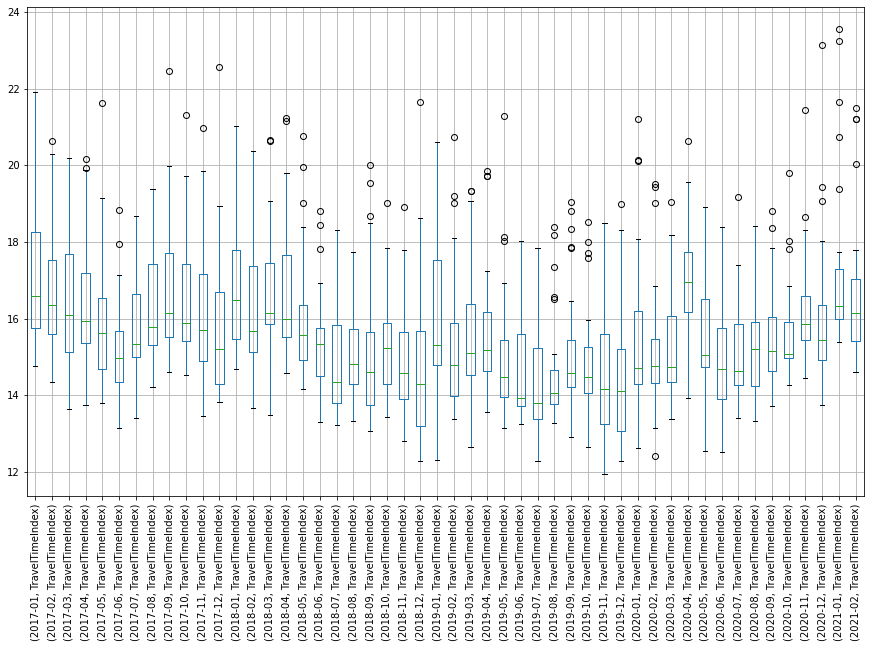

In [21]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
ts = Travel_time_df[['TravelTimeIndex', 'date_time']].loc[Travel_time_df.date_time>=datetime.datetime(2017,1, 1)]
ts.index = Travel_time_df.loc[Travel_time_df.date_time>=datetime.datetime(2017,1, 1)].date_time
ts.drop(['date_time'], inplace = True, axis = 1)
#ts.index.periods = 1861
ts.index.freq = "D"
#box_plt1 = ax.boxplot(ts.groupby(lambda x: x.strftime("%Y-%m")))
box_plt1 = ts.groupby(lambda x: x.strftime("%Y-%m")).boxplot(subplots=False, figsize=(15,9), rot=90)
# for patch in zip(box_plt['boxes']):
#         patch.set_facecolor('r')
#box_plt.set_facecolor('r')

In [22]:
#Calculating monthly travel time index 
Travel_time_df_monthly = Travel_time_df[['Trip_seconds_','Trip_miles_','date_time']].loc[(Travel_time_df.date_time>=datetime.datetime(2017,1, 1)) & (Travel_time_df.date_time<=datetime.datetime(2020,2, 29))]
#Crearing year-week date column
Travel_time_df_monthly ['year_month'] = Travel_time_df_monthly.apply(lambda row : row.date_time.strftime('%Y-%m'), axis = 1 )
#Aggregating weekly
Travel_time_df_monthly = Travel_time_df_monthly.groupby(['year_month']).agg(
{
    'Trip_seconds_':'sum',
    'Trip_miles_':'sum',
    'date_time':'first'
})
Travel_time_df_monthly = Travel_time_df_monthly.rename(columns={'date_time': 'month_start_date'})
Travel_time_df_monthly['travel_time_index'] = Travel_time_df_monthly['Trip_miles_']/Travel_time_df_monthly['Trip_seconds_']*3600

In [23]:
#Time series modeling
decomposition = seasonal_decompose(Travel_time_df_monthly.travel_time_index, freq=12)  
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

No handles with labels found to put in legend.


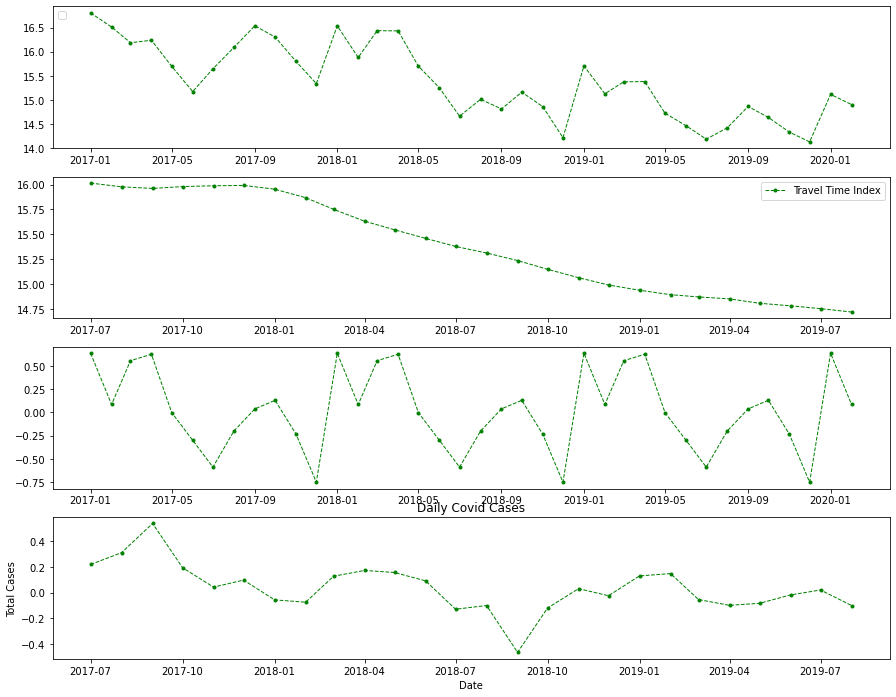

In [24]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))
# plt.figure(figsize = [15,4])
# ax1 = plt.gca()
plt.xlabel('Date') 
ax1.legend(loc='upper left')
# naming the y axis 
plt.ylabel('Total Cases')
plt.title('Daily Covid Cases') 
pl1 =ax1.plot(Travel_time_df_monthly.month_start_date, Travel_time_df_monthly.travel_time_index, color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Travel Time Index')
pl2 =ax2.plot(Travel_time_df_monthly.month_start_date, trend, color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Travel Time Index')
pl3 =ax3.plot(Travel_time_df_monthly.month_start_date, seasonal, color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Travel Time Index')

pl4 =ax4.plot(Travel_time_df_monthly.month_start_date, residual, color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Travel Time Index')

ax2.legend(loc='upper right')

No handles with labels found to put in legend.


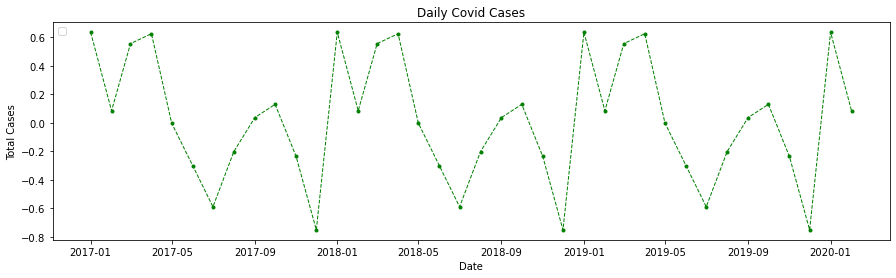

In [25]:
plt.figure(figsize = [15,4])
ax1 = plt.gca()
plt.xlabel('Date') 
ax1.legend(loc='upper left')
# naming the y axis 
plt.ylabel('Total Cases')
plt.title('Daily Covid Cases') 
pl2 =ax1.plot(Travel_time_df_monthly.month_start_date, seasonal, color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Travel Time Index')
ax2.legend(loc='upper right')

In [26]:
#Determing and plotting rolling statistics
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 

Results of Dickey-Fuller Test:
Test Statistic                 -2.647883
p-value                         0.083499
#Lags Used                      0.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


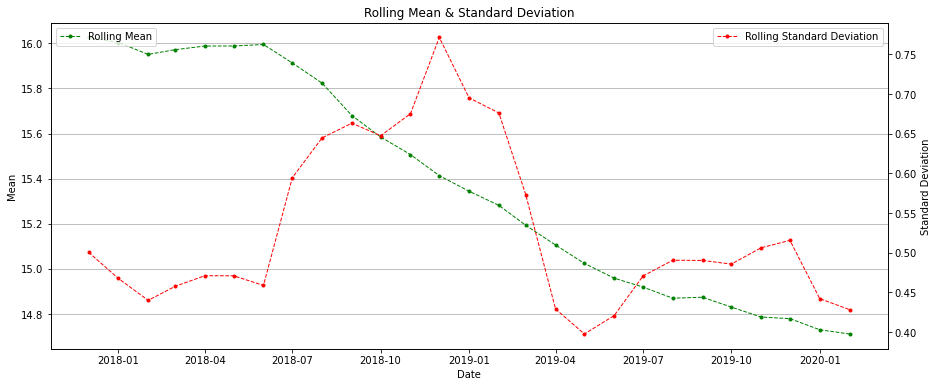

In [29]:
#testing stationarity 
#Determing rolling statistics
timeseries = Travel_time_df_monthly.travel_time_index
rolmean = timeseries.rolling(12).mean()
rolstd = timeseries.rolling(12).std()

plt.figure(figsize = [15,6])
ax1 = plt.gca()
plt1 =ax1.plot(Travel_time_df_monthly.month_start_date, rolmean, color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Rolling Mean')
plt.xlabel('Date') 
ax1.legend(loc='upper left')
# naming the y axis 
plt.ylabel('Mean')
plt.title('Rolling Mean & Standard Deviation') 
ax2 = ax1.twinx()
plt2 =ax2.plot(Travel_time_df_monthly.month_start_date, rolstd, color='red', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='red', markersize=3,label='Rolling Standard Deviation')
ax2.set_ylabel('Standard Deviation')
ax2.legend(loc='upper right')
ax1.yaxis.grid(True)

#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(timeseries, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput) 

In [38]:
series = Travel_time_df_monthly.travel_time_index
model = ARIMA(series, order=(0,1,0), seasonal_order=(1,1,1,12),)
#model = ARIMA(series, order=(5,1,0))
results  = model.fit()
print(model.fit().summary())
# line plot of residuals
residuals = pd.DataFrame(model.fit().resid)
output = results.forecast(12)

                                     SARIMAX Results                                      
Dep. Variable:                  travel_time_index   No. Observations:                   38
Model:             ARIMA(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                  -9.695
Date:                            Wed, 08 Jun 2022   AIC                             25.390
Time:                                    16:45:55   BIC                             29.047
Sample:                                01-01-2017   HQIC                            26.405
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4326      0.641     -0.675      0.499      -1.688       0.823
ma.S.L12      -0.9663     42.834   

In [33]:
# Calculating monthly average speed (full period)
Travel_time_df_monthly_fp = Travel_time_df[['Trip_seconds_','Trip_miles_','date_time']].loc[(Travel_time_df.date_time>=datetime.datetime(2017,1, 1))]
#Crearing year-week date column
Travel_time_df_monthly_fp ['year_month'] = Travel_time_df_monthly_fp.apply(lambda row : row.date_time.strftime('%Y-%m'), axis = 1 )
#Aggregating weekly
Travel_time_df_monthly_fp = Travel_time_df_monthly_fp.groupby(['year_month']).agg(
{
    'Trip_seconds_':'sum',
    'Trip_miles_':'sum',
    'date_time':'first'
})
Travel_time_df_monthly_fp = Travel_time_df_monthly_fp.rename(columns={'date_time': 'month_start_date'})
Travel_time_df_monthly_fp['Average_Travel_Speed'] = Travel_time_df_monthly_fp['Trip_miles_']/Travel_time_df_monthly_fp['Trip_seconds_']*3600

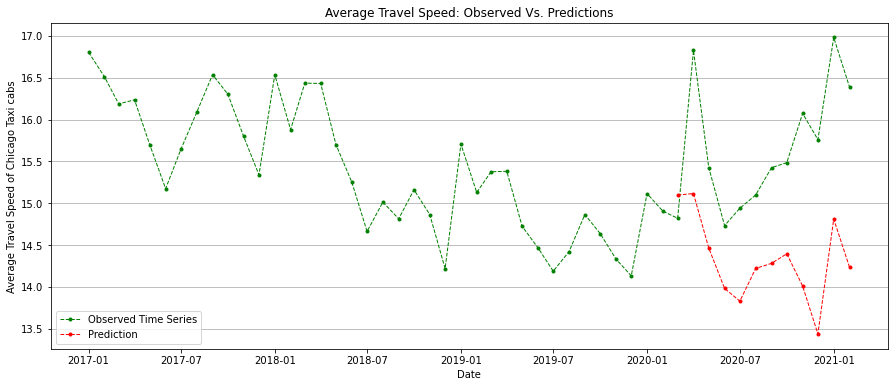

In [40]:
#Plotting taxi average travel speed: observed Vs. predictions
plt.figure(figsize = [15,6])
ax = plt.gca()
plt1 = plt.plot(Travel_time_df_monthly_fp.month_start_date, Travel_time_df_monthly_fp.Average_Travel_Speed, color='green', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='green', markersize=3,label='Observed Time Series')
plt2 = plt.plot(output, color='red', linestyle='dashed', linewidth = 1, 
         marker='o', markerfacecolor='red', markersize=3,label='Prediction')
plt.legend()
plt.xlabel('Date') 
# naming the y axis 
plt.ylabel('Average Travel Speed of Chicago Taxi cabs')
plt.title('Average Travel Speed: Observed Vs. Predictions') 
ax.yaxis.grid(True)

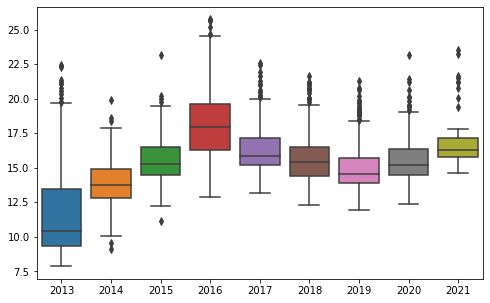

In [668]:
ts = pd.Series(Travel_time_df['TravelTimeIndex'].to_numpy(), index=pd.date_range(start=Travel_time_df.date_time[0], periods=2981 , freq="D"))
fig, ax = plt.subplots(figsize=(8,5))
seaborn.boxplot(ts.index.year, ts, ax=ax)

In [31]:
#Calculating weekly travel time index
Travel_time_df_weekly = Travel_time_df[['Trip_seconds_','Trip_miles_','date_time']]
#Crearing year-week date column
Travel_time_df_weekly ['year_week'] = Travel_time_df_weekly.apply(lambda row : row.date_time.strftime('%Y-%m'), axis = 1 )
#Aggregating weekly
Travel_time_df_weekly = Travel_time_df_weekly.groupby(['year_week']).agg(
{
    'Trip_seconds_':'sum',
    'Trip_miles_':'sum',
    'date_time':'first'
})
Travel_time_df_weekly = Travel_time_df_weekly.rename(columns={'date_time': 'week_start_date'})
Travel_time_df_weekly['travel_time_index'] = Travel_time_df_weekly['Trip_miles_']/Travel_time_df_weekly['Trip_seconds_']*3600

In [475]:
#COVID-19 Community Vulnerability Index (CCVI)
CCVI = pd.read_csv('data/Chicago_COVID-19_Community_Vulnerability_Index__CCVI_.csv')
CCVI['Community_Area'] = pd.to_numeric(CCVI['Community_Area'])
CCVI['CCVI_Score'] = pd.to_numeric(CCVI['CCVI_Score'])
CCVI = CCVI[['Community_Area', 'CCVI_Score']]

In [512]:
#Loading social indices: Community CCVI, case rate, amd pick up change percentage 
comm_picks_cases_CCVI = pd.read_csv('data/CCVI_caseRate_VolChange.csv')

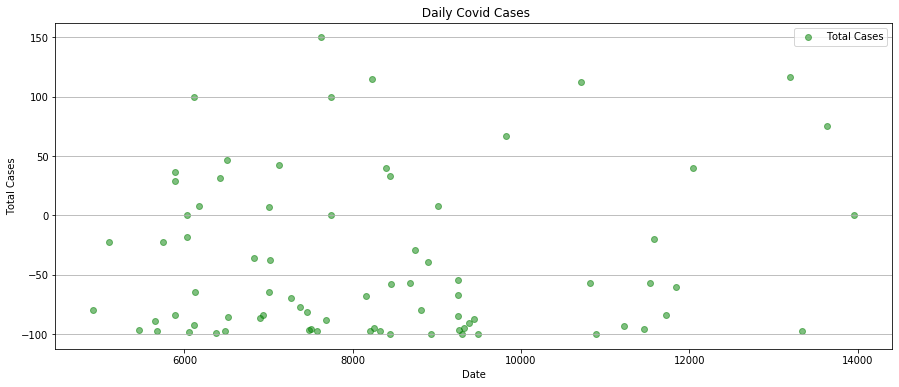

In [528]:
comm_picks_cases_CCVI = comm_picks_cases_CCVI. sort_values (['case_rate'], ascending=[1])
plt.figure(figsize = [15,6])
ax = plt.gca()
plt1 = plt.scatter(comm_picks_cases_CCVI.case_rate, comm_picks_cases_CCVI['pchange_percentage_II'], c="g", alpha=0.5, 
                   marker="o", label='Total Cases')
plt.legend()
plt.legend()
plt.xlabel('Date') 
# naming the y axis 
plt.ylabel('Total Cases')
plt.title(' Daily Covid Cases') 
ax.yaxis.grid(True)


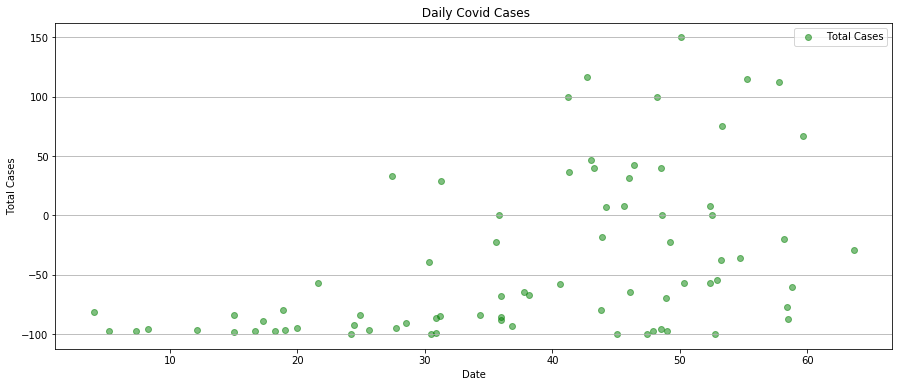

In [527]:
comm_picks_cases_CCVI = comm_picks_cases_CCVI. sort_values (['CCVI_Score'], ascending=[1])
plt.figure(figsize = [15,6])
ax = plt.gca()
plt1 = plt.scatter(comm_picks_cases_CCVI.CCVI_Score, comm_picks_cases_CCVI['pchange_percentage_II'], c="g", alpha=0.5, 
                   marker="o", label='Total Cases')
plt.legend()
plt.xlabel('Date') 
# naming the y axis 
plt.ylabel('Total Cases')
plt.title(' Daily Covid Cases') 
ax.yaxis.grid(True)


In [529]:
all_data = [np.random.normal(0, std, size=100) for std in range(1, 4)]

In [543]:
low = comm_picks_cases_CCVI.loc[comm_picks_cases_CCVI.CCVI_Category == 'LOW'].pchange_percentage_II.to_list()
meduim = comm_picks_cases_CCVI.loc[comm_picks_cases_CCVI.CCVI_Category == 'MEDIUM'].pchange_percentage_II.to_list()
high = comm_picks_cases_CCVI.loc[comm_picks_cases_CCVI.CCVI_Category == 'HIGH'].pchange_percentage_II.to_list()

Text(0, 0.5, 'Observed values')

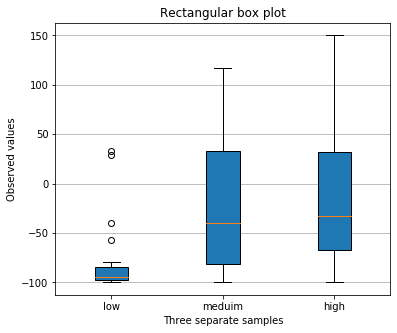

In [551]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
bplot1 = ax1.boxplot([low, meduim, high],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=['low', 'meduim', 'high'])  # will be used to label x-ticks

ax1.set_title('Rectangular box plot')
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Three separate samples')
    ax.set_ylabel('Observed values')